# import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import cv2
import glob
import sys
import random
import warnings
import math as m
import skimage.io
import skimage.filters
import skimage.morphology
from PIL import Image
from itertools import chain
from imageio import imread
from itertools import compress
from pathlib import Path
import natsort
import tensorflow as tf
# from ipynb.fs.defs.fp_2dunet_v7_kfoldfit import unet, getTrain, getTest, DiceCoef
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras import backend as K

# import data

In [ ]:
# import data
# !unzip /content/drive/MyDrive/BME548L_FinalProject/KFold/original_images.zip
# !unzip /content/drive/MyDrive/BME548L_FinalProject/KFold/combined_masks.zip
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/original_images.zip
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/combined_masks.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/original_images.zip
   creating: original_images/
  inflating: original_images/T0012AMRT(S)-0025.bmp  
  inflating: original_images/T0012AMRT(S)-0026.bmp  
  inflating: original_images/T0012AMRT(S)-0027.bmp  
  inflating: original_images/T0012AMRT(S)-0028.bmp  
  inflating: original_images/T0012AMRT(S)-0029.bmp  
  inflating: original_images/T0012AMRT(S)-0030.bmp  
  inflating: original_images/T0012AMRT(S)-0031.bmp  
  inflating: original_images/T0012AMRT(S)-0032.bmp  
  inflating: original_images/T0012AMRT(S)-0033.bmp  
  inflating: original_images/T0012AMRT(S)-0034.bmp  
  inflating: original_images/T0012AMRT(S)-0035.bmp  
  inflating: original_images/T0012AMRT(S)-0036.bmp  
  inflating: original_images/T0012AMRT(S)-0037.bmp  
  inflating: original_images/T0012AMRT(S)-0038.bmp  
  inflating: original_images/T0012AMRT(S)-0039.bmp  
  inflating: original_images/T0012AMRT(S)-0040.bmp  
  inflating: original_images/T0012A

In [ ]:
image_directory = '/content/original_images'
mask_directory = '/content/combined_masks'


# Define data parameters

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
batch_size = 8
SIZE = 256

# Define functions

In [ ]:
# get image and mask data for k-fold cross validation
def getTest(TestSubName, path, name=False):
    # if type == 'Mask':
      dataset = []
      data_name = []
      # print((TestSubName[0]))
      all_images = glob.glob(os.path.join(path, TestSubName[0]+'*'))
      all_images.sort(reverse=False)
      # print(all_images)
      for i, image_name in enumerate(all_images):
      # print(image_name)
        # if image_name.split('.')[1] == 'bmp':
        image = cv2.imread(image_name, 0)
        # print(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        data_name.append(image_name.split('.')[0].split('/')[-1])
      # if type == 'Mask':
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      if name:
          return dataset, data_name
      else:
          return dataset

def getTrain(restSubName, path, name=False):  
    # if type == 'Train':
      dataset = []
      data_name = []
      for i, rest_sub_name in enumerate(restSubName):
        # print(rest_sub_name)
        all_images = glob.glob(os.path.join(path, rest_sub_name+'*'))
        all_images.sort(reverse=False)
        # print(all_images)
        for i, image_name in enumerate(all_images):
          image = cv2.imread(image_name, 0)
          # print(image)
          image = Image.fromarray(image)
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))
      # if type == 'Mask':
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      data_name.append(image_name.split('.')[0].split('/')[-1])
      if name:
          return dataset, data_name
      else:
          return dataset

In [ ]:
def DiceCoef(y_true, y_pred, smooth=1):
    # # y_pred_thresholded = y_pred > 0.5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # dice = np.array(dice)
    return dice

# find true postive pixels (where 1=1)
def TP(ground_truth, predicted):
    gt_dex = np.where(ground_truth == 1)
    pred_corres = predicted[gt_dex]
    pred_dex = np.array(np.where(pred_corres == 1))
    return pred_dex.shape[1]


# find true negative pixels (where 0=0)
def TN(ground_truth, predicted):
    gt_dex = np.where(ground_truth == 0)
    pred_corres = predicted[gt_dex]
    pred_dex = np.array(np.where(pred_corres == 0))
    return pred_dex.shape[1]


# find false positive pixels, predicts and event where there isn't one (where 1=0)
def FP(ground_truth, predicted):
    gt_dex = np.where(ground_truth == 0)
    pred_corres = predicted[gt_dex]
    pred_dex = np.array(np.where(pred_corres == 1))
    return pred_dex.shape[1]


# find false negative pixels, misses the occurrence of an event (where 0=1)
def FN(ground_truth, predicted):
    gt_dex = np.where(ground_truth == 1)
    pred_corres = predicted[gt_dex]
    pred_dex = np.array(np.where(pred_corres == 0))
    return pred_dex.shape[1]


def get_metrics(pred, label):
    predictions = pred[:,:,:,0]
    manual_masks = label[:,:,:,0]
    # calculate pixels in each image of testing set
    true_positive = np.zeros(manual_masks.shape[0])
    true_negative = np.zeros(manual_masks.shape[0])
    false_positive = np.zeros(manual_masks.shape[0])
    false_negative = np.zeros(manual_masks.shape[0])

    for i in range(manual_masks.shape[0]):
      true_positive[i] = TP(manual_masks[i,:,:], predictions[i,:,:])
      true_negative[i] = TN(manual_masks[i,:,:], predictions[i,:,:])
      false_positive[i] = FP(manual_masks[i,:,:], predictions[i,:,:])
      false_negative[i] = FN(manual_masks[i,:,:], predictions[i,:,:])

    # calculate accuracy, precision, and sensitivity
    acc = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
    prec = true_positive/(true_positive+false_positive)
    sens = true_positive/(true_positive+false_negative)
    accuracy1 = np.mean(acc[~np.isnan(acc)])
    print('Accuracy:', accuracy1)
    precision1 = np.mean(prec[~np.isnan(prec)])
    print('Precision:', precision1)
    sensitivity1 = np.mean(sens[~np.isnan(sens)])
    print('Sensitivity:', sensitivity1)

    return accuracy1, precision1, sensitivity1

# Define models

## UNet model

In [ ]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # l1 = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    # p5 = MaxPooling2D((2,2))(c5)

    # decoding
    d6 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(c5)
    d6 = concatenate([d6, c4])  # d6=d6+c4
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    d7 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(c6)
    d7 = concatenate([d7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    d8 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(c7)
    d8 = concatenate([d8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    d9 = Conv2DTranspose(16, (2, 2), strides=2, padding='same')(c8)
    d9 = concatenate([d9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return Model(inputs=[inputs], outputs=[outputs])

## UNet with physical layer

In [ ]:
# Implementation of physcial layer
# create high pass filter from FT
# width = 256, height = 256, n is the spectrum of low frequencies to block out (must be less than 128)
def HPF(width, height, n):
    # calculate the center point
    half_w, half_h = int(width/2), int(height/2)
    # initiate high pass filter
    HPF = np.ones((width, height))
    # block out low frequencies
    HPF[:, half_h-n:half_h+n+1] = 0
    return HPF
    # fftshift with tensorflow


def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1//2:, :], A[..., :s1//2, :]], axis=-2)
    A = tf.concat([A[..., :, s2//2:], A[..., :, :s2//2]], axis=-1)
    return A

In [ ]:
# Custom Layer
class PL_HPF(tf.keras.layers.Layer):
    def __init__(self):
        super(PL_HPF, self).__init__()
        
    def build(self, input_shape=(256,256,1)):
        self.filter = HPF(width=x_train.shape[1], height=x_train.shape[2], n=1)
        # self.filter = tf.cast(self.filter, dtype=tf.complex64)
        self.filter = tf.Variable(self.filter, trainable=True, dtype=tf.complex64)

    def get_filter(self):
        return self.filter

    def call(self, input):
        # trasnpose input shape (:, 256, 256, 1) to make shape (:, 1, 256, 256)
        x = tf.transpose(input, [0, 3, 1, 2])
        # convert to complex tensor
        x = tf.cast(x, dtype=tf.complex64)
        # apply 2D FT
        x = tf.signal.fft2d(x)
        # shift FT
        x = tf_fftshift2(x)
        # element-wise multiplication of HPF with FT of image
        x = tf.multiply(x, self.filter)
        # shift back
        x = tf_fftshift2(x)
        # inverse 2D FT
        x = tf.signal.ifft2d(x)
        # abolute value
        x = tf.abs(x)
        # transpose back to original shape
        x = tf.transpose(x, [0, 2, 3, 1])
        # convert back to float tensor
        x = tf.cast(x, dtype=tf.float32)      
        return x

In [ ]:
# build the 2-D unet model with physical layer
def PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # l1 = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # physical layer
    PL = PL_HPF()(s)

    # encoding
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(PL)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    # p5 = MaxPooling2D((2,2))(c5)

    # decoding
    d6 = Conv2DTranspose(128, (2,2), strides=2, padding='same')(c5)
    d6 = concatenate([d6, c4]) # d6=d6+c4
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    d7 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c6)
    d7 = concatenate([d7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    d8 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c7)
    d8 = concatenate([d8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    d9 = Conv2DTranspose(16, (2,2), strides=2, padding='same')(c8)
    d9 = concatenate([d9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

# UNet Model data evaluation
*   Make sure testSubName is changed for each iteration 
*   Get labels and original images from test data
*   Verify test subjects and number of data being obtained
*   Change variable names accordingly (prediction_PL etc)




## 3-Folds evaluation

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
trained_models = ['meniscus_epoch80_f1_dce_0.67.hdf5',
                  'meniscus_epoch80_f2_dce_0.72.hdf5',
                  'meniscus_epoch80_f3_dce_0.72.hdf5']
accuracy_UN = []
precision_UN = []
sensitivity_UN = []
dice_UN = []
for i, testSubName in enumerate(Y):
    dsc_ls = []
    prediction_UN = []
    testSubName = [testSubName]
    trainSubName = list(set(Y) - set(testSubName))
    print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
    pred_path = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/TrainedModels/'+trained_models[i]
    print(trained_models[i])
    model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    model.load_weights(pred_path) # need to change out this hdf5 model for each subject
    x_test_UN = getTest(testSubName, image_directory)
    y_test_UN = getTest(testSubName, mask_directory)

    val_dataset_UN = tf.data.Dataset.from_tensor_slices((x_test_UN, y_test_UN))
    val_dataset_UN = val_dataset_UN.batch(1)

    for x_batch_val, y_batch_val in val_dataset_UN:
        val_logits = model(x_batch_val)
        # Update val metrics
        y_batch_val = tf.cast(y_batch_val, dtype='float32')
        y_pred = tf.cast((val_logits > 0.5), dtype='float32')
        dsc = DiceCoef(y_batch_val, y_pred)
        dsc_ls.append(dsc.numpy())
        y_p = np.squeeze(y_pred, axis=0)
        prediction_UN.append(y_p)
    dice = np.mean(dsc_ls)   
    prediction_UN_np = np.array(prediction_UN)

    accuracy, precision, sensitivity = get_metrics(prediction_UN_np, y_test_UN)

    accuracy_UN.append(accuracy)
    precision_UN.append(precision)
    sensitivity_UN.append(sensitivity)
    dice_UN.append(dice)

print('Averaged accuracy for 3-folds:', np.mean(accuracy_UN))
print('Averaged precision for 3-folds:', np.mean(precision_UN))
print('Averaged sensitivity for 3-folds:', np.mean(sensitivity_UN))
print('Averaged dice coefficient for 3-folds:', np.mean(dice_UN))

testsub:  ['T0012'] trainSubNames:  ['T0014', 'T0013']
meniscus_epoch80_f1_dce_0.67.hdf5


<ipython-input-22-4da979cb5f0a>:59: RuntimeWarning: invalid value encountered in true_divide
  prec = true_positive/(true_positive+false_positive)
<ipython-input-22-4da979cb5f0a>:60: RuntimeWarning: invalid value encountered in true_divide
  sens = true_positive/(true_positive+false_negative)


Accuracy: 0.9992516326255386
Precision: 0.9026165847419978
Sensitivity: 0.48231888639430137
testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
meniscus_epoch80_f2_dce_0.72.hdf5
Accuracy: 0.9996659112671876
Precision: 0.7906209426616457
Sensitivity: 0.6773814187059128
testsub:  ['T0014'] trainSubNames:  ['T0012', 'T0013']
meniscus_epoch80_f3_dce_0.72.hdf5
Accuracy: 0.9995851107381821
Precision: 0.7654399170563014
Sensitivity: 0.8026868576244844
Averaged accuracy for 3-folds: 0.9995008848769694
Averaged precision for 3-folds: 0.819559148153315
Averaged sensitivity for 3-folds: 0.6541290542415662
Averaged dice coefficient for 3-folds: 0.7031186


## Get predictions from best model

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
testSubName = 'T0013'
testSubName = [testSubName]
trainSubName = list(set(Y) - set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_test.shape)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(1)
dsc_ls = []
prediction = []
# tf.compat.v1.disable_eager_execution()
# prediction = tf.compat.v1.placeholder(tf.float32)
# tf.compat.v1.enable_eager_execution()
model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.load_weights('/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/meniscus_epoch80_T0013_dce_074.hdf5') # need to change out this hdf5 model for each subject
for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    y_batch_val = tf.cast(y_batch_val, dtype='float32')
    y_pred = tf.cast((val_logits > 0.5), dtype='float32')
    dsc = DiceCoef(y_batch_val, y_pred)
    dsc_ls.append(dsc.numpy())
    y_p = np.squeeze(y_pred, axis=0)
    prediction.append(y_p)

testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
(139, 256, 256, 1)


# UNet-PL Model data evaluation

*   Make sure testSubName is changed for each iteration 
*   Get labels and original images from test data
*   Verify test subjects and number of data being obtained
*   Change variable names accordingly (prediction_PL etc)




## 3-Folds evaluation

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
trained_models = ['meniscus_epoch80_f1.hdf5',
                  'meniscus_epoch80_f2.hdf5',
                  'meniscus_epoch80_f3.hdf5']
accuracy_UN = []
precision_UN = []
sensitivity_UN = []
dice_UN = []
for i, testSubName in enumerate(Y):
    dsc_ls = []
    prediction_UN = []
    testSubName = [testSubName]
    trainSubName = list(set(Y) - set(testSubName))
    x_train = getTrain(trainSubName, image_directory)
    y_train = getTrain(trainSubName, mask_directory)
    print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
    pred_path = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/TrainedModels_PL/Copy of '+trained_models[i]
    print(trained_models[i])
    model = PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    model.load_weights(pred_path) # need to change out this hdf5 model for each subject
    x_test_UN = getTest(testSubName, image_directory)
    y_test_UN = getTest(testSubName, mask_directory)

    val_dataset_UN = tf.data.Dataset.from_tensor_slices((x_test_UN, y_test_UN))
    val_dataset_UN = val_dataset_UN.batch(1)

    for x_batch_val, y_batch_val in val_dataset_UN:
        val_logits = model(x_batch_val)
        # Update val metrics
        y_batch_val = tf.cast(y_batch_val, dtype='float32')
        y_pred = tf.cast((val_logits > 0.5), dtype='float32')
        dsc = DiceCoef(y_batch_val, y_pred)
        dsc_ls.append(dsc.numpy())
        y_p = np.squeeze(y_pred, axis=0)
        prediction_UN.append(y_p)
    dice = np.mean(dsc_ls)   
    prediction_UN_np = np.array(prediction_UN)

    accuracy, precision, sensitivity = get_metrics(prediction_UN_np, y_test_UN)

    accuracy_UN.append(accuracy)
    precision_UN.append(precision)
    sensitivity_UN.append(sensitivity)
    dice_UN.append(dice)

print('Averaged accuracy for 3-folds:', np.mean(accuracy_UN))
print('Averaged precision for 3-folds:', np.mean(precision_UN))
print('Averaged sensitivity for 3-folds:', np.mean(sensitivity_UN))
print('Averaged dice coefficient for 3-folds:', np.mean(dice_UN))

testsub:  ['T0012'] trainSubNames:  ['T0014', 'T0013']
meniscus_epoch80_f1.hdf5


<ipython-input-22-4da979cb5f0a>:59: RuntimeWarning: invalid value encountered in true_divide
  prec = true_positive/(true_positive+false_positive)
<ipython-input-22-4da979cb5f0a>:60: RuntimeWarning: invalid value encountered in true_divide
  sens = true_positive/(true_positive+false_negative)


Accuracy: 0.9993140914700173
Precision: 0.9088423349504825
Sensitivity: 0.5475747994140547
testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
meniscus_epoch80_f2.hdf5
Accuracy: 0.9997040293125307
Precision: 0.852070904627939
Sensitivity: 0.7005705425106621
testsub:  ['T0014'] trainSubNames:  ['T0012', 'T0013']
meniscus_epoch80_f3.hdf5
Accuracy: 0.9993900629435248
Precision: 0.8516664253164506
Sensitivity: 0.5372753845679341
Averaged accuracy for 3-folds: 0.9994693945753577
Averaged precision for 3-folds: 0.8708598882982908
Averaged sensitivity for 3-folds: 0.595140242164217
Averaged dice coefficient for 3-folds: 0.6721147


## Get predictions from best model

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
testSubName = 'T0013'
testSubName = [testSubName]
trainSubName = list(set(Y) - set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test_PL = getTest(testSubName, image_directory)
y_test_PL = getTest(testSubName, mask_directory)
print(x_test.shape)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(1)

dsc_ls = []
prediction_PL = []

model = PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.load_weights('/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/TrainedModels_PL/Copy of meniscus_epoch80_f2.hdf5') # need to change out this hdf5 model for each subject
for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    y_batch_val = tf.cast(y_batch_val, dtype='float32')
    y_pred = tf.cast((val_logits > 0.5), dtype='float32')
    dsc = DiceCoef(y_batch_val, y_pred)
    dsc_ls.append(dsc.numpy())
    y_p = np.squeeze(y_pred, axis=0)
    prediction_PL.append(y_p)

testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
(139, 256, 256, 1)


# UNet-BiconNet Model data evaluation

*   Make sure testSubName is changed for each iteration 
*   Get labels and original images from test data
*   Verify test subjects and number of data being obtained
*   Change variable names accordingly (prediction_PL etc)




## 3-Folds evaluation

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
dice_BN = [0.7280, 0.7946, 0.7650]
accuracy_BN = []
precision_BN = []
sensitivity_BN = []
for i, testSubName in enumerate(Y):
    testSubName = [testSubName]
    trainSubName = list(set(Y) - set(testSubName))
    print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
    pred_path = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/BiconNet_Prediction/'+str(i+1)
    prediction_BN = getTest(testSubName, pred_path)
    x_test_BN = getTest(testSubName, image_directory)
    y_test_BN = getTest(testSubName, mask_directory)
    print(x_test_BN.shape)

    val_dataset_BN = tf.data.Dataset.from_tensor_slices((x_test_BN, y_test_BN))
    val_dataset_BN = val_dataset_BN.batch(1)

    accuracy, precision, sensitivity = get_metrics(prediction_BN, y_test_BN)

    accuracy_BN.append(accuracy)
    precision_BN.append(precision)
    sensitivity_BN.append(sensitivity)

print('Averaged accuracy for 3-folds:', np.mean(accuracy_BN))
print('Averaged precision for 3-folds:', np.mean(precision_BN))
print('Averaged sensitivity for 3-folds:', np.mean(sensitivity_BN))
print('Averaged dice coefficient for 3-folds:', np.mean(dice_BN))

testsub:  ['T0012'] trainSubNames:  ['T0014', 'T0013']
(146, 256, 256, 1)


<ipython-input-22-4da979cb5f0a>:59: RuntimeWarning: invalid value encountered in true_divide
  prec = true_positive/(true_positive+false_positive)
<ipython-input-22-4da979cb5f0a>:60: RuntimeWarning: invalid value encountered in true_divide
  sens = true_positive/(true_positive+false_negative)


Accuracy: 0.9993778734671782
Precision: 0.9570791572059177
Sensitivity: 0.5522023519128993
testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
(139, 256, 256, 1)
Accuracy: 0.999816693056636
Precision: 0.9155399763812517
Sensitivity: 0.7440628352862941
testsub:  ['T0014'] trainSubNames:  ['T0012', 'T0013']
(137, 256, 256, 1)
Accuracy: 0.9997873228799662
Precision: 0.8847193281490253
Sensitivity: 0.7922631940261787
Averaged accuracy for 3-folds: 0.9996606298012601
Averaged precision for 3-folds: 0.9191128205787317
Averaged sensitivity for 3-folds: 0.6961761270751241
Averaged dice coefficient for 3-folds: 0.7625333333333333


## Get predictions from best model

In [ ]:
Y = ['T0012', 'T0013', 'T0014']
dice_BN = [0.7280, 0.7946, 0.7650]
accuracy_BN = []
precision_BN = []
sensitivity_BN = []

testSubName = ['T0013']
trainSubName = list(set(Y) - set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
pred_path = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/BiconNet_Prediction/'+str(2)
prediction_BN = getTest(testSubName, pred_path)
x_test_BN = getTest(testSubName, image_directory)
y_test_BN = getTest(testSubName, mask_directory)
print(x_test_BN.shape)

testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
(139, 256, 256, 1)


# Plot model prediction comparison

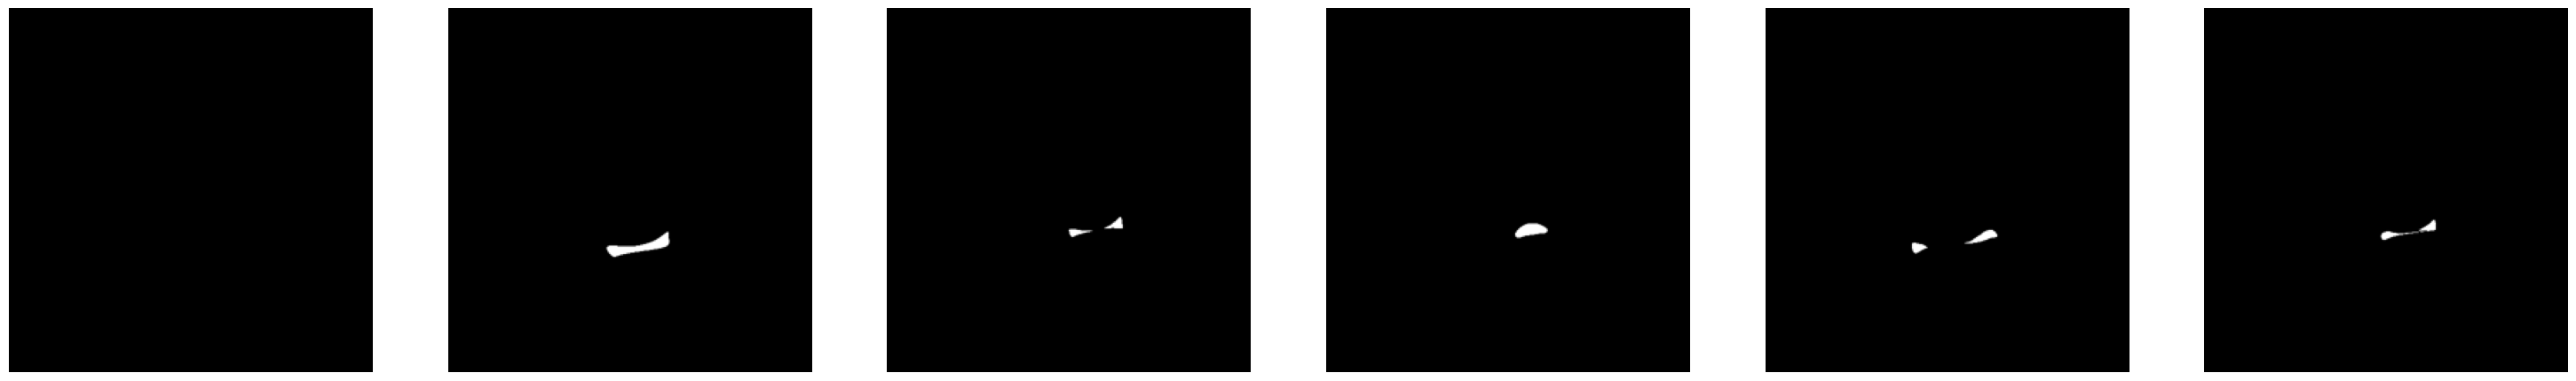

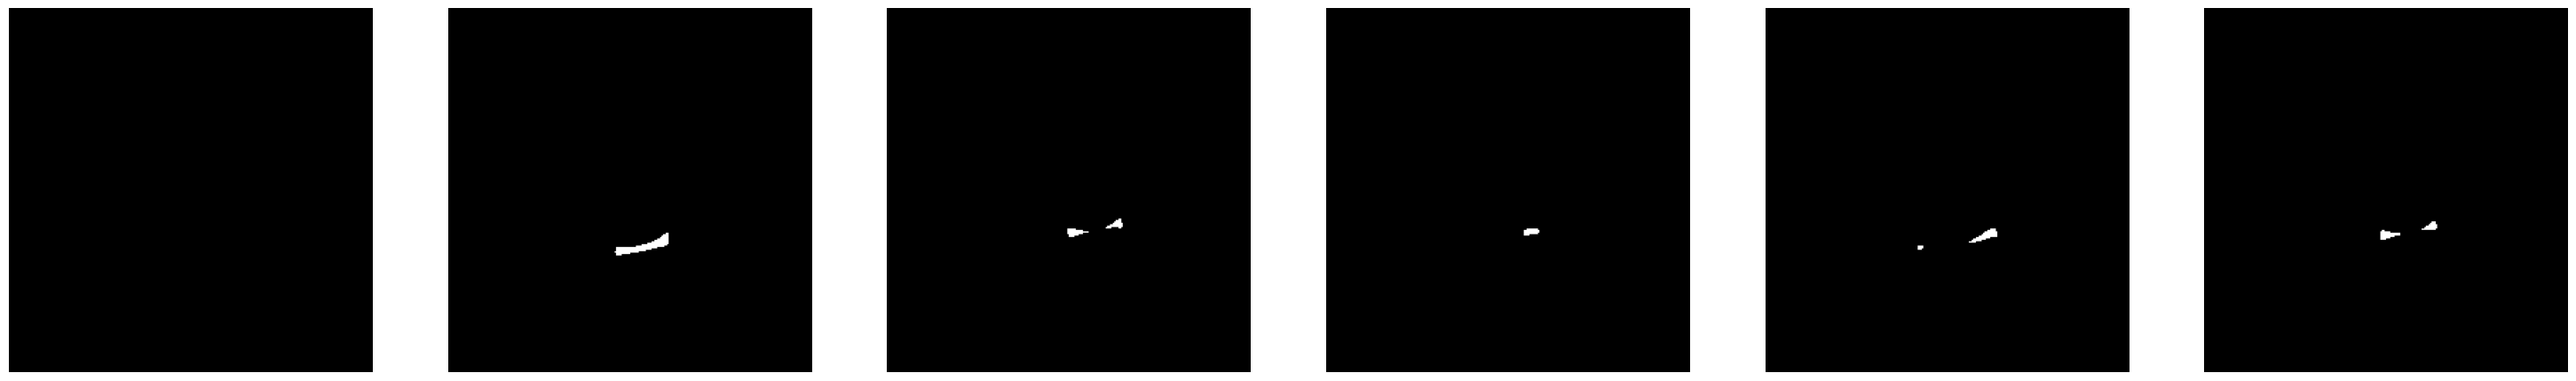

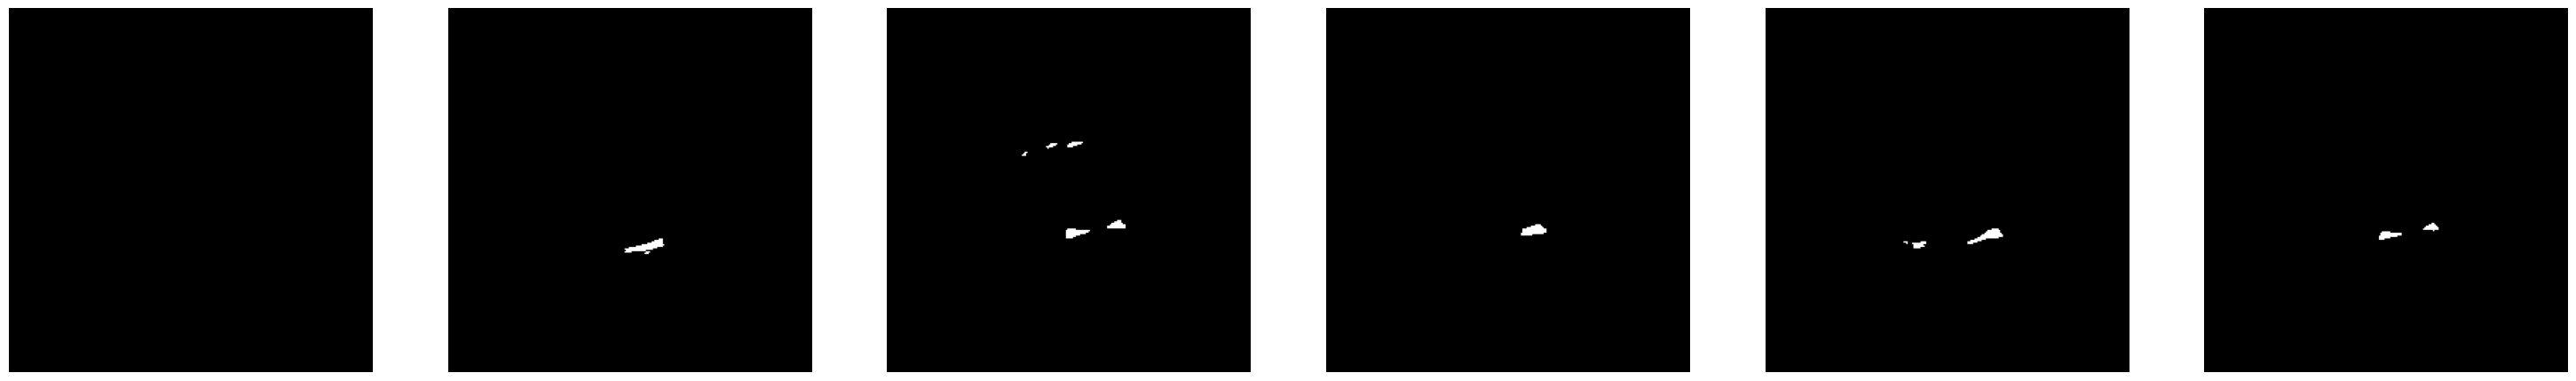

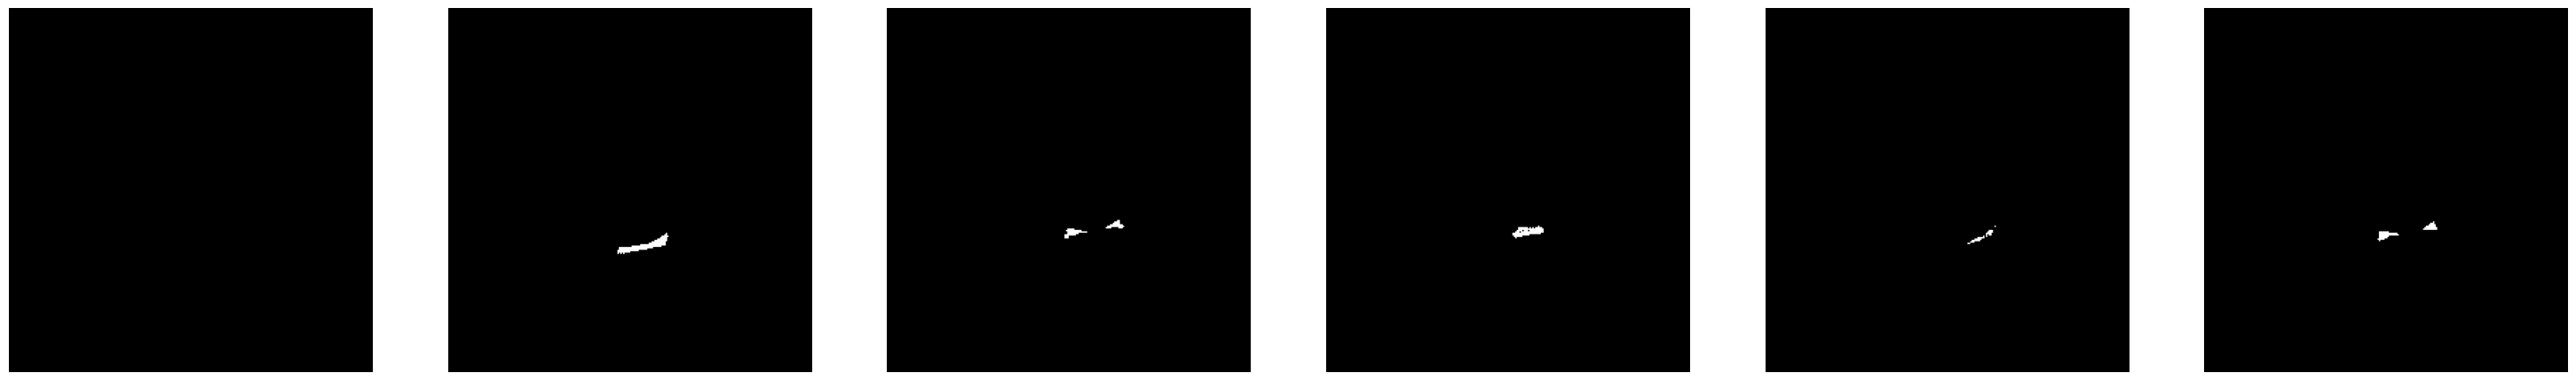

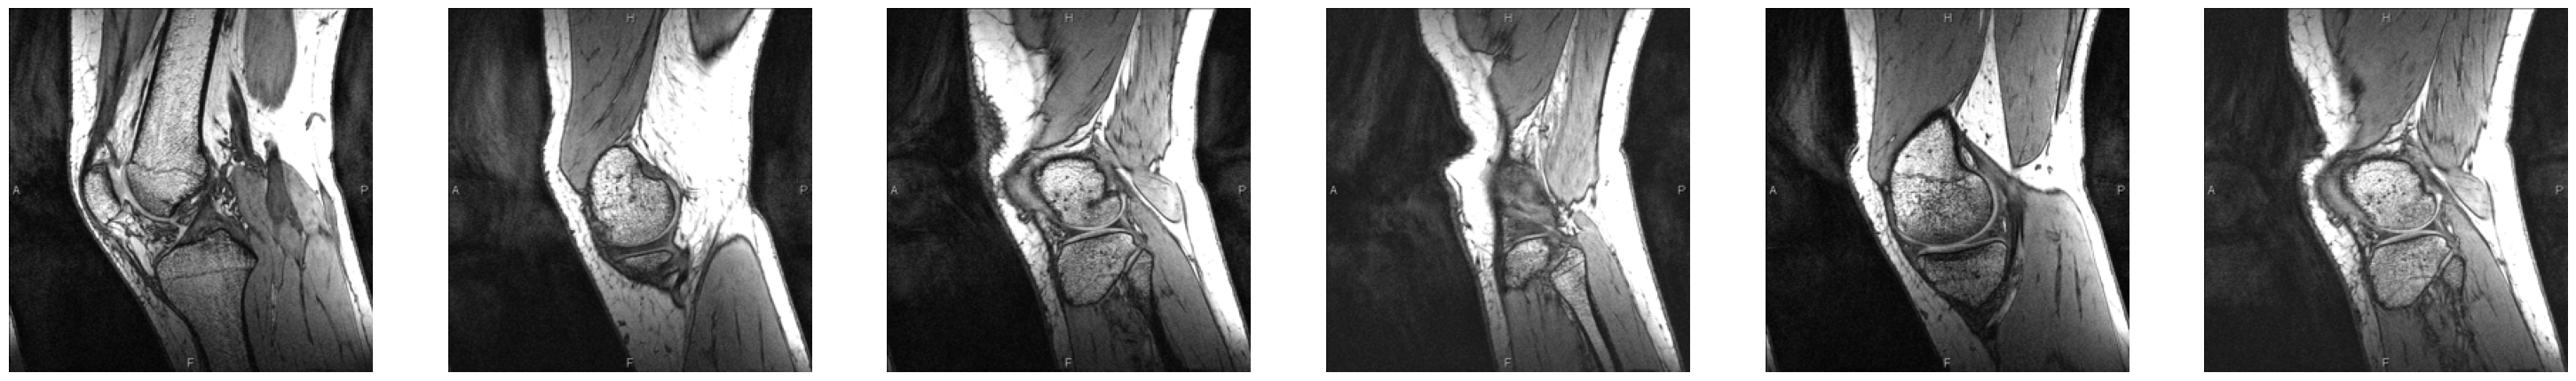

In [ ]:
from sklearn.utils import shuffle

import matplotlib.gridspec as gridspec
def plot_examples(batch):
    plt.figure(figsize=(50,50))
    for i in range(len(batch)):
        plt.subplot(8, 8, i+1)
        plt.imshow(batch[i])
        gs1 = gridspec.GridSpec(8, 8)
        gs1.update(wspace=0.0025, hspace=0.05)
        plt.axis('off')
        plt.gray()
    plt.show()
    gs1.update(wspace=0.0025, hspace=0.05)

y_test, prediction_BN, prediction, prediction_PL, x_test = shuffle(y_test, prediction_BN, prediction, prediction_PL, x_test, random_state=0)
plot_examples(np.sum(y_test[63:69], axis=3)) # display the test images
plot_examples(np.sum(prediction_BN[63:69],axis=3)) # display the test masks
plot_examples(np.sum(prediction[63:69],axis=3)) # display the test masks
plot_examples(np.sum(prediction_PL[63:69],axis=3)) # display the test masks
plot_examples(np.sum(x_test[63:69], axis=3)) # display thresholded images